# Mathematical Foundations of Graph Neural Networks (Part 1)

## 1. Introduction to Graph Theory Notation

Graph Neural Networks operate on graph-structured data, so we first need to establish the mathematical notation for graphs as used in Scarselli et al.'s paper.

### 1.1 Basic Graph Notation

A graph $G$ is defined as a tuple $G = (V, E)$ where:
- $V$ is a set of nodes (vertices)
- $E \subseteq V \times V$ is a set of edges, where each edge is a pair of nodes

#### Additional Notation:
- $N$ is the number of nodes in the graph: $N = |V|$
- For each node $v \in V$, we define:
  - $ne[v]$: The neighbors of $v$ (nodes connected to $v$ by an edge)
  - $co[v]$: The edges connected to node $v$
  - $in[v]$: The incoming edges to node $v$ (for directed graphs)
  - $out[v]$: The outgoing edges from node $v$ (for directed graphs)

### 1.2 Labels and Features

In practical applications, nodes and edges often have associated labels or features:

- $L_V$ is a set of node labels
- $L_E$ is a set of edge labels
- $l_V: V \rightarrow L_V$ is a function that assigns labels to nodes
- $l_E: E \rightarrow L_E$ is a function that assigns labels to edges

In the context of GNNs, we typically represent these as feature vectors:
- $x_v \in \mathbb{R}^{d_v}$ is the feature vector for node $v$
- $x_{(v,u)} \in \mathbb{R}^{d_e}$ is the feature vector for edge $(v,u)$

Where $d_v$ and $d_e$ are the dimensions of node and edge features, respectively.

## 2. State Vectors in GNNs

The core concept in GNNs is assigning a **state vector** to each node in the graph.

### 2.1 Definition of State Vectors

For each node $v \in V$, we define a state vector $h_v \in \mathbb{R}^s$ where $s$ is the state dimension.

The state vector $h_v$ encodes information about:
- The node's own features
- The structural information of the node's neighborhood
- Information propagated from distant nodes in the graph

In Scarselli's GNN model, these state vectors are computed iteratively until they reach a stable equilibrium.

### 2.2 Relationship to Fixed Points

The state vectors are computed as fixed points of a local transition function. Mathematically, at equilibrium:

$$h_v = f_w(x_v, x_{co[v]}, h_{ne[v]}, x_{ne[v]})$$

Where:
- $f_w$ is the local transition function with parameters $w$
- $x_v$ is the feature vector of node $v$
- $x_{co[v]}$ represents the features of edges connected to $v$
- $h_{ne[v]}$ represents the state vectors of all neighbors of $v$
- $x_{ne[v]}$ represents the feature vectors of all neighbors of $v$

### 2.3 The Concept of Information Diffusion

The iterative computation of state vectors can be viewed as an information diffusion process:
1. Each node starts with an initial state (often initialized randomly or based on node features)
2. In each iteration, nodes update their states based on information from their neighbors
3. Information gradually propagates (or diffuses) through the graph
4. The process continues until convergence, at which point each node's state contains information from the entire graph

## 3. Code Implementation: Graph Representation

Let's implement the basic data structures needed to represent graphs in the context of GNNs:

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Any, Optional

class GraphData:
    """
    A class to represent graph data for GNN processing.
    """
    def __init__(self):
        """Initialize an empty graph."""
        self.nodes = {}  # Dictionary mapping node ID to node features
        self.edges = {}  # Dictionary mapping (source, target) to edge features
        self.node_states = {}  # Dictionary mapping node ID to state vector
        
    def add_node(self, node_id: Any, features: np.ndarray) -> None:
        """
        Add a node to the graph with its features.
        
        Args:
            node_id: Unique identifier for the node
            features: Node feature vector (numpy array)
        """
        self.nodes[node_id] = features
        
    def add_edge(self, source: Any, target: Any, features: Optional[np.ndarray] = None) -> None:
        """
        Add an edge to the graph with optional features.
        
        Args:
            source: Source node ID
            target: Target node ID
            features: Edge feature vector (optional)
        """
        # Ensure nodes exist
        if source not in self.nodes or target not in self.nodes:
            raise ValueError("Both source and target nodes must exist before adding an edge")
            
        # Add edge with features (or empty features if None provided)
        if features is None:
            features = np.array([])
            
        self.edges[(source, target)] = features
        
    def get_neighbors(self, node_id: Any) -> List[Any]:
        """
        Get all neighbors of a node.
        
        Args:
            node_id: Node identifier
            
        Returns:
            List of neighbor node IDs
        """
        return [target for (source, target) in self.edges if source == node_id]
        
    def get_neighbor_states(self, node_id: Any) -> Dict[Any, np.ndarray]:
        """
        Get states of all neighbors of a node.
        
        Args:
            node_id: Node identifier
            
        Returns:
            Dictionary mapping neighbor IDs to their state vectors
        """
        neighbors = self.get_neighbors(node_id)
        return {neighbor: self.node_states.get(neighbor, np.zeros(1)) for neighbor in neighbors}
        
    def get_connected_edges(self, node_id: Any) -> Dict[Tuple[Any, Any], np.ndarray]:
        """
        Get all edges connected to a node.
        
        Args:
            node_id: Node identifier
            
        Returns:
            Dictionary mapping (source, target) to edge features
        """
        return {edge: features for edge, features in self.edges.items() 
                if edge[0] == node_id or edge[1] == node_id}
                
    def initialize_states(self, state_dim: int) -> None:
        """
        Initialize state vectors for all nodes.
        
        Args:
            state_dim: Dimension of state vectors
        """
        for node_id in self.nodes:
            self.node_states[node_id] = np.zeros(state_dim)
            
    def update_state(self, node_id: Any, new_state: np.ndarray) -> None:
        """
        Update the state vector of a node.
        
        Args:
            node_id: Node identifier
            new_state: New state vector
        """
        self.node_states[node_id] = new_state
        
    def get_adjacency_matrix(self) -> np.ndarray:
        """
        Compute the adjacency matrix of the graph.
        
        Returns:
            Adjacency matrix as numpy array
        """
        node_ids = list(self.nodes.keys())
        n = len(node_ids)
        adj_matrix = np.zeros((n, n))
        
        # Create a mapping from node IDs to indices
        node_to_idx = {node_id: i for i, node_id in enumerate(node_ids)}
        
        # Fill the adjacency matrix
        for (source, target) in self.edges:
            source_idx = node_to_idx[source]
            target_idx = node_to_idx[target]
            adj_matrix[source_idx, target_idx] = 1
            
        return adj_matrix

This implementation provides the basic data structures we need to represent graph data for GNN processing. In the next part, we'll implement functions to create and manipulate graph data.

## 4. Creating and Manipulating Graphs

Building on our basic graph representation, let's implement functions to create and manipulate graphs for GNN computations.

### 4.1 Creating Example Graphs

In [2]:
def create_example_graph() -> GraphData:
    """
    Create a simple example graph for demonstration.
    
    Returns:
        GraphData object representing a simple graph
    """
    graph = GraphData()
    
    # Add nodes with features
    graph.add_node(0, np.array([1.0, 0.0]))  # Node 0 with 2D feature
    graph.add_node(1, np.array([0.8, 0.2]))  # Node 1 with 2D feature
    graph.add_node(2, np.array([0.6, 0.4]))  # Node 2 with 2D feature
    graph.add_node(3, np.array([0.4, 0.6]))  # Node 3 with 2D feature
    graph.add_node(4, np.array([0.2, 0.8]))  # Node 4 with 2D feature
    
    # Add edges with optional features
    graph.add_edge(0, 1, np.array([1.0]))  # Edge from 0 to 1 with feature 1.0
    graph.add_edge(0, 2, np.array([0.8]))  # Edge from 0 to 2 with feature 0.8
    graph.add_edge(1, 2, np.array([0.6]))  # Edge from 1 to 2 with feature 0.6
    graph.add_edge(2, 3, np.array([0.4]))  # Edge from 2 to 3 with feature 0.4
    graph.add_edge(3, 4, np.array([0.2]))  # Edge from 3 to 4 with feature 0.2
    
    # Initialize states with 3D state vectors
    graph.initialize_states(state_dim=3)
    
    return graph

### 4.2 Converting Between Representations

In practice, we often need to convert between different graph representations. Let's implement some conversion functions:


In [3]:
def networkx_to_graph_data(G: nx.Graph, node_feature_dim: int, edge_feature_dim: int) -> GraphData:
    """
    Convert a NetworkX graph to our GraphData representation.
    
    Args:
        G: NetworkX graph
        node_feature_dim: Dimension of node features
        edge_feature_dim: Dimension of edge features
        
    Returns:
        GraphData object
    """
    graph = GraphData()
    
    # Add nodes with random features if not present
    for node in G.nodes():
        if 'features' in G.nodes[node]:
            features = G.nodes[node]['features']
        else:
            features = np.random.rand(node_feature_dim)
        graph.add_node(node, features)
    
    # Add edges with random features if not present
    for source, target in G.edges():
        if 'features' in G.edges[(source, target)]:
            features = G.edges[(source, target)]['features']
        else:
            features = np.random.rand(edge_feature_dim)
        graph.add_edge(source, target, features)
    
    return graph

def graph_data_to_networkx(graph: GraphData) -> nx.Graph:
    """
    Convert our GraphData to a NetworkX graph.
    
    Args:
        graph: GraphData object
        
    Returns:
        NetworkX graph
    """
    G = nx.Graph()
    
    # Add nodes with features
    for node_id, features in graph.nodes.items():
        G.add_node(node_id, features=features)
        
    # Add edges with features
    for (source, target), features in graph.edges.items():
        G.add_edge(source, target, features=features)
        
    return G

### 4.3 Creating Specialized Graph Types

Let's implement functions to create specific types of graphs that are commonly used in GNN research:

In [4]:
def create_grid_graph(rows: int, cols: int, feature_dim: int = 2) -> GraphData:
    """
    Create a grid graph with given dimensions.
    
    Args:
        rows: Number of rows
        cols: Number of columns
        feature_dim: Dimension of node features
        
    Returns:
        GraphData object representing a grid graph
    """
    # Create a grid graph using NetworkX
    G = nx.grid_2d_graph(rows, cols)
    
    # Convert to our GraphData representation
    graph = GraphData()
    
    # Add nodes with position-based features
    for node in G.nodes():
        i, j = node
        # Normalize positions to [0, 1]
        pos_i = i / (rows - 1) if rows > 1 else 0.5
        pos_j = j / (cols - 1) if cols > 1 else 0.5
        
        # Create feature vector (first two dimensions are position, rest are random)
        features = np.random.rand(feature_dim)
        features[0] = pos_i
        features[1] = pos_j if feature_dim > 1 else pos_i
        
        graph.add_node(node, features)
    
    # Add edges without features
    for (source, target) in G.edges():
        graph.add_edge(source, target)
    
    return graph

def create_random_graph(num_nodes: int, edge_probability: float, feature_dim: int = 2) -> GraphData:
    """
    Create a random Erdos-Renyi graph.
    
    Args:
        num_nodes: Number of nodes
        edge_probability: Probability of edge creation between any two nodes
        feature_dim: Dimension of node features
        
    Returns:
        GraphData object representing a random graph
    """
    # Create a random graph using NetworkX
    G = nx.erdos_renyi_graph(num_nodes, edge_probability)
    
    # Convert to our GraphData representation
    graph = GraphData()
    
    # Add nodes with random features
    for node in G.nodes():
        features = np.random.rand(feature_dim)
        graph.add_node(node, features)
    
    # Add edges without features
    for (source, target) in G.edges():
        graph.add_edge(source, target)
    
    return graph

## 5. Graph Visualization

Visualization is crucial for understanding GNNs. Let's implement functions to visualize graphs and their state vectors:

In [5]:
def visualize_graph(graph: GraphData, title: str = "Graph Visualization") -> None:
    """
    Visualize a graph with node features and states.
    
    Args:
        graph: GraphData object
        title: Plot title
    """
    # Convert to NetworkX for visualization
    G = graph_data_to_networkx(graph)
    
    # Create a spring layout
    pos = nx.spring_layout(G)
    
    plt.figure(figsize=(10, 8))
    plt.title(title)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7)
    
    # Create labels showing node ID and state
    labels = {}
    for node_id in graph.nodes:
        if node_id in graph.node_states:
            state_str = str(graph.node_states[node_id])
            state_str = state_str[:5] + "..." if len(state_str) > 8 else state_str
            labels[node_id] = f"{node_id}\n{state_str}"
        else:
            labels[node_id] = f"{node_id}"
    
    nx.draw_networkx_labels(G, pos, labels, font_size=10)
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_state_evolution(graph: GraphData, states_history: List[Dict[Any, np.ndarray]], 
                              max_iterations: int = 3) -> None:
    """
    Visualize how states evolve over iterations.
    
    Args:
        graph: GraphData object
        states_history: List of dictionaries mapping node IDs to states at each iteration
        max_iterations: Maximum number of iterations to display
    """
    # Convert to NetworkX for visualization
    G = graph_data_to_networkx(graph)
    
    # Create a spring layout (consistent across iterations)
    pos = nx.spring_layout(G, seed=42)
    
    # Limit iterations to display
    iterations = min(len(states_history), max_iterations)
    
    # Create subplots
    fig, axes = plt.subplots(1, iterations, figsize=(5*iterations, 6))
    if iterations == 1:
        axes = [axes]  # Make sure axes is a list for consistent indexing
    
    # For each iteration
    for t in range(iterations):
        ax = axes[t]
        states = states_history[t]
        
        # Update node colors based on state magnitude
        node_colors = []
        for node_id in G.nodes():
            if node_id in states:
                # Use the norm of the state vector for color intensity
                state_norm = np.linalg.norm(states[node_id])
                # Normalize to [0,1] range for colormap
                color_value = min(state_norm / 2.0, 1.0)  # Assuming most states have norm < 2
                node_colors.append(plt.cm.Blues(color_value))
            else:
                node_colors.append('lightgray')
        
        # Draw the graph for this iteration
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, ax=ax)
        nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7, ax=ax)
        
        # Create labels showing node ID and state
        labels = {}
        for node_id in G.nodes():
            if node_id in states:
                state_str = str(states[node_id])
                state_str = state_str[:5] + "..." if len(state_str) > 8 else state_str
                labels[node_id] = f"{node_id}\n{state_str}"
            else:
                labels[node_id] = f"{node_id}"
        
        nx.draw_networkx_labels(G, pos, labels, font_size=10, ax=ax)
        
        ax.set_title(f"Iteration {t+1}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

## 6. Mathematical Properties of GNN Operators

Now, let's dive deeper into the mathematical properties of the GNN operators, particularly the local transition function.

### 6.1 Contraction Mapping

In Scarselli's paper, a crucial mathematical property of the GNN local transition function is that it must be a **contraction mapping** to guarantee convergence of the iterative process.

A function $f: X \rightarrow X$ is a contraction mapping on a metric space $(X, d)$ if there exists a constant $0 \leq \mu < 1$ such that:

$$d(f(x), f(y)) \leq \mu \cdot d(x, y) \quad \forall x, y \in X$$

Where $d$ is a distance metric.

For GNNs, this means the local transition function $f_w$ must be a contraction with respect to the node states. This ensures that when we iteratively apply $f_w$, the node states will converge to a unique fixed point.

### 6.2 Banach Fixed-Point Theorem

The convergence of the GNN state computation is guaranteed by the **Banach fixed-point theorem**, which states:

Let $(X, d)$ be a non-empty complete metric space, and let $f: X \rightarrow X$ be a contraction mapping. Then:
1. $f$ has a unique fixed point $x^*$ in $X$
2. For any starting point $x_0 \in X$, the sequence $\{x_n\}$ defined by $x_n = f(x_{n-1})$ converges to $x^*$

For GNNs, this theorem guarantees that:
1. There exists a unique equilibrium state for each node
2. The iterative state computation will converge to this equilibrium state regardless of the initial state

### 6.3 Mathematical Formulation of Iterations

Given the local transition function $f_w$, the state update equation for a node $v$ at iteration $t$ is:

$$h_v^{(t)} = f_w(x_v, x_{co[v]}, h_{ne[v]}^{(t-1)}, x_{ne[v]})$$

For the entire graph, we can define a global transition function $F_w$ that updates all node states at once:

$$\mathbf{h}^{(t)} = F_w(\mathbf{x}, \mathbf{h}^{(t-1)})$$

Where $\mathbf{h}^{(t)}$ and $\mathbf{x}$ are the collections of all node states and features, respectively.

The iterative process continues until convergence:

$$\mathbf{h}^{(\infty)} = F_w(\mathbf{x}, \mathbf{h}^{(\infty)})$$

This is the fixed point of $F_w$, which exists and is unique if $F_w$ is a contraction mapping.

## 7. Implementing a Simple GNN Framework

Now, let's implement a basic GNN framework based on the mathematical foundations we've explored.

### 7.1 Local Transition Function

The local transition function is the core component of a GNN. According to Scarselli et al., this function can be implemented in various ways, but it must be a contraction mapping.

Let's implement a simple linear version:

In [6]:
def linear_transition_function(node_features: np.ndarray,
                               edge_features: Dict[Tuple[Any, Any], np.ndarray],
                               neighbor_states: Dict[Any, np.ndarray],
                               W: np.ndarray,
                               U: np.ndarray,
                               b: np.ndarray) -> np.ndarray:
    """
    Linear transition function for updating node states.
    
    Args:
        node_features: Features of the node
        edge_features: Dictionary mapping (source, target) to edge features
        neighbor_states: Dictionary mapping neighbor IDs to their state vectors
        W: Weight matrix for node features
        U: Weight matrix for aggregating neighbor states
        b: Bias vector
        
    Returns:
        Updated state vector
    """
    # Apply transformation to node features
    node_term = np.dot(W, node_features)
    
    # Aggregate neighbor states
    neighbor_sum = np.zeros_like(b)
    for neighbor, state in neighbor_states.items():
        neighbor_sum += np.dot(U, state)
    
    # Apply bias and activation function (tanh to ensure contraction)
    new_state = np.tanh(node_term + neighbor_sum + b)
    
    return new_state

This function implements a simple linear transformation of the node's features and its neighbors' states, followed by a hyperbolic tangent activation function to ensure the contraction property.

### 7.2 State Update Process

Now, let's implement the iterative process for updating node states:

In [7]:
def update_states(graph: GraphData, 
                 W: np.ndarray, 
                 U: np.ndarray, 
                 b: np.ndarray,
                 max_iterations: int = 10,
                 convergence_threshold: float = 1e-4) -> List[Dict[Any, np.ndarray]]:
    """
    Update node states iteratively until convergence.
    
    Args:
        graph: GraphData object
        W: Weight matrix for node features
        U: Weight matrix for aggregating neighbor states
        b: Bias vector
        max_iterations: Maximum number of iterations
        convergence_threshold: Threshold for convergence
        
    Returns:
        List of dictionaries mapping node IDs to states at each iteration
    """
    # Initialize states if not already initialized
    state_dim = b.shape[0]
    if not graph.node_states:
        graph.initialize_states(state_dim)
    
    # Store state history for visualization
    states_history = [{node_id: state.copy() for node_id, state in graph.node_states.items()}]
    
    # Iterate until convergence or max_iterations
    for t in range(max_iterations):
        # Store old states for convergence check
        old_states = {node_id: state.copy() for node_id, state in graph.node_states.items()}
        
        # Update each node's state
        for node_id in graph.nodes:
            # Get node features
            node_features = graph.nodes[node_id]
            
            # Get connected edge features
            edge_features = graph.get_connected_edges(node_id)
            
            # Get neighbor states
            neighbor_states = graph.get_neighbor_states(node_id)
            
            # Update state using transition function
            new_state = linear_transition_function(
                node_features, edge_features, neighbor_states, W, U, b
            )
            
            # Update node state
            graph.update_state(node_id, new_state)
        
        # Add current states to history
        states_history.append({node_id: state.copy() for node_id, state in graph.node_states.items()})
        
        # Check for convergence
        max_diff = 0.0
        for node_id in graph.nodes:
            diff = np.linalg.norm(graph.node_states[node_id] - old_states[node_id])
            max_diff = max(max_diff, diff)
        
        if max_diff < convergence_threshold:
            print(f"Converged after {t+1} iterations")
            break
    
    return states_history

### 7.3 Output Function

In Scarselli's GNN model, each node produces an output through a local output function. Let's implement a simple linear output function:

In [8]:
def linear_output_function(node_features: np.ndarray,
                          node_state: np.ndarray,
                          A: np.ndarray,
                          c: np.ndarray) -> np.ndarray:
    """
    Linear output function for producing node outputs.
    
    Args:
        node_features: Features of the node
        node_state: State vector of the node
        A: Weight matrix for node state
        c: Bias vector
        
    Returns:
        Output vector
    """
    # Apply transformation to state
    output = np.dot(A, node_state) + c
    
    return output

def compute_outputs(graph: GraphData, A: np.ndarray, c: np.ndarray) -> Dict[Any, np.ndarray]:
    """
    Compute outputs for all nodes in the graph.
    
    Args:
        graph: GraphData object with updated states
        A: Weight matrix for node state
        c: Bias vector
        
    Returns:
        Dictionary mapping node IDs to output vectors
    """
    outputs = {}
    
    for node_id in graph.nodes:
        node_features = graph.nodes[node_id]
        node_state = graph.node_states[node_id]
        outputs[node_id] = linear_output_function(node_features, node_state, A, c)
    
    return outputs

## 8. Complete Framework Integration

Let's integrate all components into a complete GNN framework:

In [9]:
class SimpleGNN:
    """
    A simple implementation of the Graph Neural Network model.
    """
    def __init__(self, node_feature_dim: int, state_dim: int, output_dim: int):
        """
        Initialize a simple GNN.
        
        Args:
            node_feature_dim: Dimension of node features
            state_dim: Dimension of node state vectors
            output_dim: Dimension of node outputs
        """
        # Initialize weights randomly
        self.W = np.random.randn(state_dim, node_feature_dim) * 0.1
        self.U = np.random.randn(state_dim, state_dim) * 0.1
        self.b = np.random.randn(state_dim) * 0.1
        
        self.A = np.random.randn(output_dim, state_dim) * 0.1
        self.c = np.random.randn(output_dim) * 0.1
        
        # Ensure contraction property (spectral radius < 1)
        # This is a simplified approach for educational purposes
        U_eigenvalues = np.linalg.eigvals(self.U)
        spectral_radius = np.max(np.abs(U_eigenvalues))
        if spectral_radius >= 1:
            self.U = self.U / (spectral_radius * 1.1)  # Scale to ensure spectral radius < 1
    
    def process_graph(self, graph: GraphData, max_iterations: int = 10) -> Dict[Any, np.ndarray]:
        """
        Process a graph with the GNN model.
        
        Args:
            graph: GraphData object
            max_iterations: Maximum number of iterations for state updates
            
        Returns:
            Dictionary mapping node IDs to output vectors
        """
        # Update states until convergence
        states_history = update_states(
            graph, self.W, self.U, self.b, max_iterations
        )
        
        # Compute outputs for all nodes
        outputs = compute_outputs(graph, self.A, self.c)
        
        return outputs, states_history

## 9. Example: Running the GNN on a Simple Graph

Let's create a simple example to demonstrate our GNN framework:

Graph has 5 nodes and 5 edges
Converged after 6 iterations

Node outputs:
Node 0: [0.15036362]
Node 1: [0.14408941]
Node 2: [0.14013303]
Node 3: [0.13587117]
Node 4: [0.13168796]


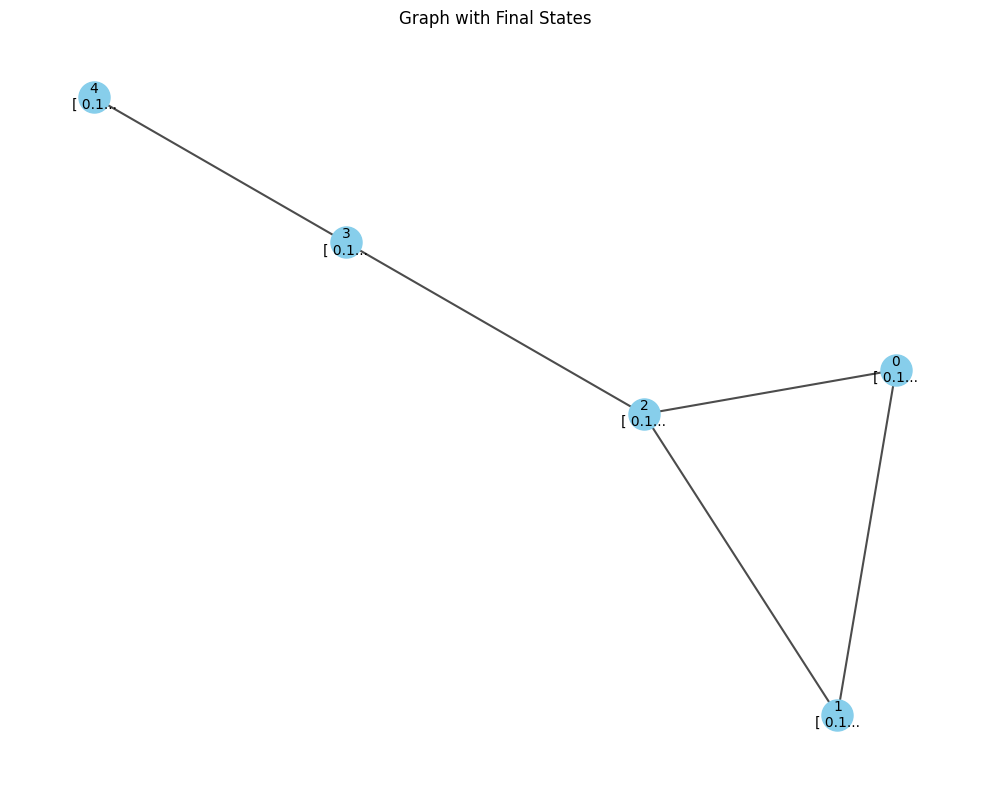

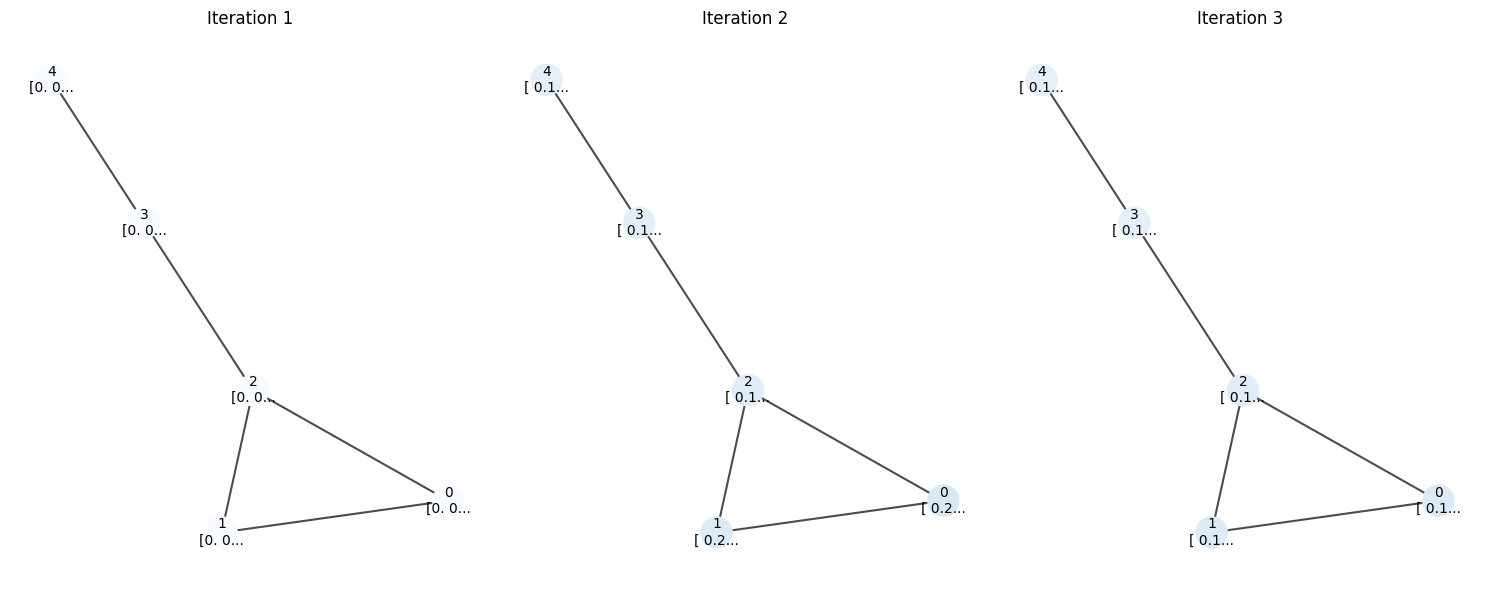

In [10]:
def run_gnn_example():
    """Run a complete example of the GNN model."""
    # Create a simple graph
    graph = create_example_graph()
    
    # Print graph information
    print(f"Graph has {len(graph.nodes)} nodes and {len(graph.edges)} edges")
    
    # Initialize GNN model
    node_feature_dim = list(graph.nodes.values())[0].shape[0]
    state_dim = 3
    output_dim = 1
    gnn = SimpleGNN(node_feature_dim, state_dim, output_dim)
    
    # Process the graph
    outputs, states_history = gnn.process_graph(graph, max_iterations=10)
    
    # Print outputs
    print("\nNode outputs:")
    for node_id, output in outputs.items():
        print(f"Node {node_id}: {output}")
    
    # Visualize the final graph with states
    visualize_graph(graph, title="Graph with Final States")
    
    # Visualize the evolution of states
    visualize_state_evolution(graph, states_history, max_iterations=3)

# Run the example
run_gnn_example()

## 10. Discussion: Mathematical Properties

Let's discuss some important mathematical properties of the GNN model:

### 10.1 Contraction Mapping and Convergence

The contraction property is crucial for the GNN model to work. In our implementation, we ensured contraction in two ways:
1. Using tanh activation function (which has a derivative bounded by 1)
2. Scaling the weight matrix U to have spectral radius < 1

This ensures that the state updating process will converge to a unique fixed point.

### 10.2 Expressiveness of GNNs

The expressiveness of a GNN model refers to its ability to distinguish different graph structures and node features. While the original GNN model by Scarselli et al. is powerful, it has some limitations:

1. It struggles to distinguish certain graph structures due to the focus on immediate neighborhoods
2. The iterative process only approximates the fixed point due to finite iterations

These limitations have led to the development of more advanced GNN architectures in recent years, such as Graph Convolutional Networks (GCNs), GraphSAGE, and Graph Attention Networks (GATs).

### 10.3 Computational Complexity

The computational complexity of the GNN model is:
- **Time complexity**: O(T * |E| * d²), where T is the number of iterations, |E| is the number of edges, and d is the state dimension
- **Space complexity**: O(|V| * d), where |V| is the number of nodes

This makes GNNs efficient for sparse graphs, where |E| is much smaller than |V|².

## 11. Exercises

1. Modify the `linear_transition_function` to include edge features in the computation.

2. Implement a non-linear version of the transition function using a multi-layer neural network.

3. Create a grid graph and visualize how information diffuses from a single node to the rest of the graph over iterations.

4. Experiment with different spectral radii for the U matrix and observe how it affects convergence speed.

5. Modify the GNN implementation to handle directed graphs, where each node aggregates information only from its incoming neighbors.

## 12. Summary and Next Steps

In this section, we've explored the mathematical foundations of Graph Neural Networks, including:
- Basic graph notation
- The concept of state vectors
- Fixed point theory and contraction mappings
- A simple implementation of the GNN model

In the next notebook, we'll delve deeper into the GNN model architecture, implementing more sophisticated versions of the local transition and output functions.